<h1><center>CMPE 462 - Quiz 4&5 <br>Implementing a Regression Tree<br>Due: May 5, 2020, 23:59</center></h1>

* **Student ID1: 2015401183**

# Introduction

Decision trees can learn rules to map features to both continous and discrete outputs. In this quiz, you will consider the continous case and implement a regression tree to predict house prices in Boston. You will also conduct small data analysis and evaluation procedures. This notebook will guide you through.

## (10 pts) Task 1: Dataset 

Run the cells below to load Boston house prices dataset using `scikit-learn`. You can find more detail on the dataset [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset). **Please use the train and test matrices we prepared for you :)**

In [1]:
import numpy as np
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
boston = load_boston()
X_y = np.column_stack([boston['data'], boston['target']])
np.random.seed(1)
np.random.shuffle(X_y)
X, y = X_y[:,:-1], X_y[:,-1]
X_train, y_train = X[:400], y[:400]
X_test, y_test = X[400:], y[400:]
del X, y, X_y

**(10 pts)** Unlike the dataset in Project 1, Boston dataset is high-dimensional and we cannot observe the relations between all features and the output with a single scatter plot. What we can do is to visualize the correlations between both features and house prices using a heatmap. So, stack the features and the outputs in a single matrix and compute correlation between all pairs of columns. Visualize the correlation coefficient matrix as a heatmap, which is $(N+1)x(N+1)$, where $N$ is the number of features in Boston dataset. You can check out `corrcoef` and `heatmap` functions from `numpy` and `seaborn` libraries, respectively. You can use diverging color palette to emphasize both positive and negative correlations.

Do you observe strong correlations between any pair of features or certain features and house price? 

In [3]:
y_train = np.reshape(y_train, (400,1))
data_train = np.concatenate((X_train, y_train), axis=1)

**Heat Map**

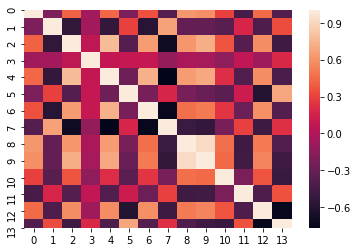

In [4]:
corr_matrix = np.corrcoef(data_train.T)
sns.heatmap(corr_matrix)

I observed that the pixel related to feature 9 and feature 10 is the brightest pixel when I compared the features. These two features has the most positive correlation other pairs. Moreover, there are black pixels and they represent strong negative correlation. It is difficult to compare black pixels however, at the scale, the highest number is about 1(completely white) and the lowest number is about -0.7(completely black). The pixels related to feature 9 and 10 is almost completely white when the scale is checked and even if the most black pixels are completely black, their absolute values can not be higher than the pixels related to feature 9 and 10. So, the most correlated features are 9 and 10.
The most correlated feature with label is feature 12. The most black pixel at the column 13(label column) is the pixel related to feature 13.

In [5]:
corr_feature_target = corr_matrix[13,:]
corr_feature_target

array([-0.38849787,  0.34369601, -0.4705726 ,  0.19644737, -0.41990334,
        0.68465709, -0.37397477,  0.2291105 , -0.39654306, -0.47040072,
       -0.49980315,  0.362833  , -0.73535657,  1.        ])

When the pixel values at the map are checked, the most correlated feature is the feature and the least correlated feature is feature 4.

## (80 pts) Task 2: Regression Tree


**(15 pts)** Let us now build the regression tree. We start by implementing the splitting criteria which is used to decide the most discriminative features at each step. We stick to lecture notes and use $RSS$ which is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-y_{L}^{*}\right)^{2}+\sum_{\text {right }}\left(y_{i}-y_{R}^{*}\right)^{2}$$

where $y_L^* and y_L^*$ are mean y-value of left and right nodes.

When you implement $RSS$, pick the most correlated and least correlated feature with the output prices according to previous step. Note that correlation can be both positive and negative! For both features, compute $RSS$ for every possible split threshold and plot thresholds versus RSS scores.

Do two features display different characteristics?

In [6]:
#for a feature, calculate and returns threshold values and its RSS values
def calc_th_rss(samples_x, samples_y):
    rss_values = []
    samples_x_thresholds = []
    sorted_samples_x = np.sort(samples_x)
    for i in range(np.size(samples_x)-1):
        if sorted_samples_x[i] != sorted_samples_x[i+1]:
            th = [(sorted_samples_x[i] + sorted_samples_x[i+1])/2]
            samples_x_thresholds.extend(th) 
    #samples_x_thresholds
    for th in samples_x_thresholds:
        left = []
        right = []
        for i in range(np.size(samples_x)):
            if samples_x[i] < th:
                left.extend(samples_y[i])
            else:
                right.extend(samples_y[i])
        avg_left = np.sum(left)/np.size(left)
        avg_right = np.sum(right)/np.size(right)
        rss = [np.dot(left - avg_left,left - avg_left) + np.dot(right - avg_right,right - avg_right)]
        rss_values.extend(rss)
    return samples_x_thresholds, rss_values

**Most Correlated**

In [7]:
samples_x = X_train[:,12]
samples_y = y_train

In [8]:
samples_x_thresholds, rss_values = calc_th_rss(samples_x, samples_y)
samples_x_thresholds[np.argmin(rss_values)] #optimal threshold

7.865

In [9]:
np.min(rss_values)#minimum RSS

18457.017449583796

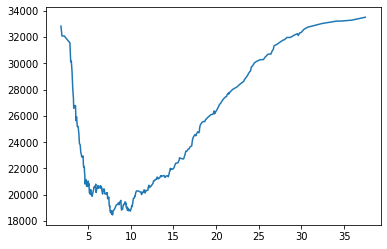

In [10]:
plt.plot(samples_x_thresholds,rss_values)

The most correlated feature is the 13.feature: LSTAT % lower status of the population.

Optimal threshold is 7.865 and RSS is 18457.02

**Least Correlated**

In [11]:
samples_x = X_train[:,3]
samples_y = y_train

In [12]:
samples_x_thresholds, rss_values = calc_th_rss(samples_x, samples_y)
samples_x_thresholds[np.argmin(rss_values)] #optimal threshold

0.5

In [13]:
np.min(rss_values)#minimum RSS

32293.54760368664

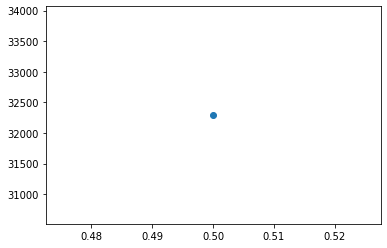

In [14]:
plt.plot(samples_x_thresholds,rss_values,marker='o')

The least correlated feature is the 4.feature: CHAS Charles River dummy variable

Min RSS value is 32293.54

### Regression Tree

**(45 pts)** Now implement the training procedure of a regression tree using $RSS$ as split criteria. Build a rule tree recursively by traversing all features and considering each split threshold to find the optimum split, at every node.

You are free to implement training procedure as a standalone function or part of a class, but in any case use maximum depth as the stopping condition.

**Best Threshold**

In [15]:
#calculates optimal threshold and min RSS for a specific feature
def calc_best_th(samples_x, samples_y):
    rss_values = []
    samples_x_thresholds = []
    sorted_samples_x = np.sort(samples_x)
    for i in range(np.size(samples_x)-1):
        if sorted_samples_x[i] != sorted_samples_x[i+1]:
            th = [(sorted_samples_x[i] + sorted_samples_x[i+1])/2]
            samples_x_thresholds.extend(th) 
    #samples_x_thresholds
    if np.min(samples_x) - np.max(samples_x) == 0:#if all features are same, they are not discriminative and useles, so rss is identified as a huge number
        return -1, 1000000
        
    for th in samples_x_thresholds:
        left = []
        right = []
        for i in range(np.size(samples_x)):
            if samples_x[i] < th:
                left.extend(samples_y[i])
            else:
                right.extend(samples_y[i])
        avg_left = np.sum(left)/np.size(left)
        avg_right = np.sum(right)/np.size(right)
        rss = [np.dot(left - avg_left,left - avg_left) + np.dot(right - avg_right,right - avg_right)]
        rss_values.extend(rss)
    best_th = samples_x_thresholds[np.argmin(rss_values)]
    rss = np.min(rss_values)
    return best_th, rss

**Best Feature**

In [16]:
#finds most discriminative feature and calculates its optimal threshold and min RSS for the feature
def calc_best_feature_th(samples_X, samples_y):
    feature_rss = np.zeros((13))
    feature_th = np.zeros((13))
    for d in range(13):
        samples_x = samples_X[:,d]
        best_th, rss = calc_best_th(samples_x, samples_y)
        feature_rss[d] = rss
        feature_th[d] = best_th
    best_feature = np.argmin(feature_rss)
    best_th = feature_th[best_feature]
    return best_feature, best_th

In [17]:
#samples_X = X_train
#samples_y = y_train
#best_feature, best_th = calc_best_feature_th(samples_X, samples_y)

**Split Samples**

In [18]:
class Node: 
    def __init__(self,X,y,d):#initial values: x samples, y samples and level
        self.left = None
        self.right = None
        self.samples_X = X#samples
        self.samples_y = y
        self.feature = None #discriminative feature
        self.th = None #threshold for the feature
        self.size = None#the number of samples
        self.price = None#if it is leaf, it is price, otherwise -1
        self.depth = d#depth

In [19]:
def tree_split(root,max_depth): 
    if np.std(root.samples_y) !=0 and root.depth<max_depth:
        root.price = -1
        #calculates best feature and its threshold
        root.feature, root.th = calc_best_feature_th(root.samples_X, root.samples_y)
        #print("feature-threshold: " , root.feature," " , root.th)#checks features and thresholds to draw tree
        #splits samples x and samples y with respect to best feature and its threshold
        left_samples_X, left_samples_y, right_samples_X, right_samples_y = split(root.samples_X,root.samples_y,root.feature,root.th)
        left_size = np.size(left_samples_X,0)
        #creates new nodes: left and right
        left_child = Node(left_samples_X,left_samples_y,root.depth+1)
        root.left = left_child
        tree_split(root.left,max_depth) 
        right_child = Node(right_samples_X,right_samples_y,root.depth+1)
        root.right = right_child
        tree_split(root.right,max_depth) 
    else:
        root.price = np.mean(root.samples_y)
        #print("leaf " , root.price)
    

In [20]:
def split(samples_X,samples_y,best_feature,best_th):
    sample_size = np.size(samples_X,0)
    left_samples_X = []
    right_samples_X = []
    left_samples_y = []
    right_samples_y = []
    for i in range (sample_size):
        if samples_X[i,best_feature] < best_th:
            if np.size(left_samples_X) == 0:
                left_samples_X = samples_X[i,:]
                left_samples_y = samples_y[i]
            else:
                left_samples_X = np.vstack((left_samples_X,samples_X[i,:])) 
                left_samples_y = np.vstack((left_samples_y,samples_y[i])) 
        else:
            if np.size(right_samples_X) == 0:
                right_samples_X = samples_X[i,:]
                right_samples_y = samples_y[i]
            else: 
                right_samples_X = np.vstack((right_samples_X,samples_X[i,:])) 
                right_samples_y = np.vstack((right_samples_y,samples_y[i]))
    return left_samples_X, left_samples_y, right_samples_X, right_samples_y

In [21]:
samples_X = X_train#training data
samples_y = y_train#training label

In [22]:
root1 = Node(samples_X,samples_y,0)

In [23]:
tree_split(root1,100)#training #100 depth it causes overfitting 

**(15 pts)** Having implemented the regression tree, now write a procedure to predict test features. Given a sample, this procedure should follow the rules learned during the training to arrive at a leaf and predict the output as the mean output of the arrived leaf samples. 

If you have implemented a regression tree class, you can insert this procedure as a class function 

In [24]:
def estimate_value(root,sample_x): 
    if root.price == -1:#if it is not leaf
        if sample_x[root.feature] < root.th:
            return(estimate_value(root.left,sample_x))
        else: 
            return(estimate_value(root.right,sample_x))
    else:
        return root.price

**Training Data Estimation**

In [25]:
sample_size = np.size(X_train,0)
estimated_training_label = np.zeros((sample_size))
actual_training_label = y_train
for i in range(sample_size):
    training_sample_x = X_train[i,:]
    estimated_training_label[i] = estimate_value(root1,training_sample_x)
training_error = actual_training_label.T-estimated_training_label
training_error

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

**Test Data Estimation**

In [26]:
sample_size = np.size(X_test,0)
estimated_test_label = np.zeros((sample_size))
actual_test_label = y_test
for i in range(sample_size):
    test_sample_x = X_test[i,:]
    estimated_test_label[i] = estimate_value(root1,test_sample_x)
test_error = actual_test_label.T-estimated_test_label
test_error

array([ -1.9,   8.4,   5.1,   1.4,   1.6,   3.9,  -0.9,  -2.6,   0.4,
        -1.1,   1.4,  -6.1,   2.2,   0.1,   9.7,  -0.6,   4.1,   0. ,
        -1.9,   0.4,   1.5,   0.7,   3.7,   6.9,  -1.8,   0. ,   1.6,
        -0.7,   0.8,   3.8,   2. ,  12.2,  -7.2,   7. ,   0.3,  -1.3,
         2.7,  -0.5,   1.4,   0. ,   4.6,   0.5,  -8.7,   1.3,  -1.2,
        -0.5,  -4.6,  -2.8,  -1.2,   2.9,  -3.8,   0.2,  -3. ,  -0.4,
        -1.7, -13.4,  -2.1,   3.2,   6.2,   2.7,   0.7,  -3.9,  -1.7,
        -2. ,   0.2,  -2.6,  -2.7,  -0.2,   8.2,  -7.7,  -0.1,   3.1,
        -2. ,  -0.5,   0.1,   3.6,  -3.5,  -3.2,  -3.5,   4.3,  -2.5,
        -7.7,   4.6,   8.9,   4.6,   2.5,  -1.6,  -1.5,  -1.3,  -0.7,
         4.1,  -0.2,   1.7,   2.3,  -0.2,  -1.6,   1.3,   0.5,   5.1,
        -1.5,   2.3,   3.4,   2.4,   0.2,   4. ,   0.7])

**(5 pts)** Train your model using a max depth of 3 and visualize the resulting tree. You can use an external tool such as draw.io or LaTeX for drawing. Annotate the nodes with split columns and thresholds. You can view the tree in this [link](https://scikit-learn.org/stable/modules/tree.html#tree) as an example. 

In [27]:
root3 = Node(samples_X,samples_y,0)#training

In [28]:
tree_split(root3,3)#training #3 depth

In [29]:
def print_tree(root):
    if root.price == -1:
        print("feature: ", root.feature, " threshold: " , root.th)
        print_tree(root.left)
        print_tree(root.right)
    else:
        print("price: " , root.price)
   

In [30]:
print_tree(root3) #Preorder (Root, Left, Right)

feature:  12  threshold:  7.865
feature:  5  threshold:  7.436999999999999
feature:  7  threshold:  1.48495
price:  50.0
price:  27.90098039215686
feature:  0  threshold:  2.654025
price:  45.80434782608695
price:  21.9
feature:  12  threshold:  15.0
feature:  7  threshold:  1.2073999999999998
price:  50.0
price:  21.374834437086093
feature:  4  threshold:  0.657
price:  17.116363636363637
price:  11.9984375


In [31]:
#calc_r2_score(root3,X_train,y_train.T)

In [32]:
#calc_r2_score(root3,X_test,y_test)

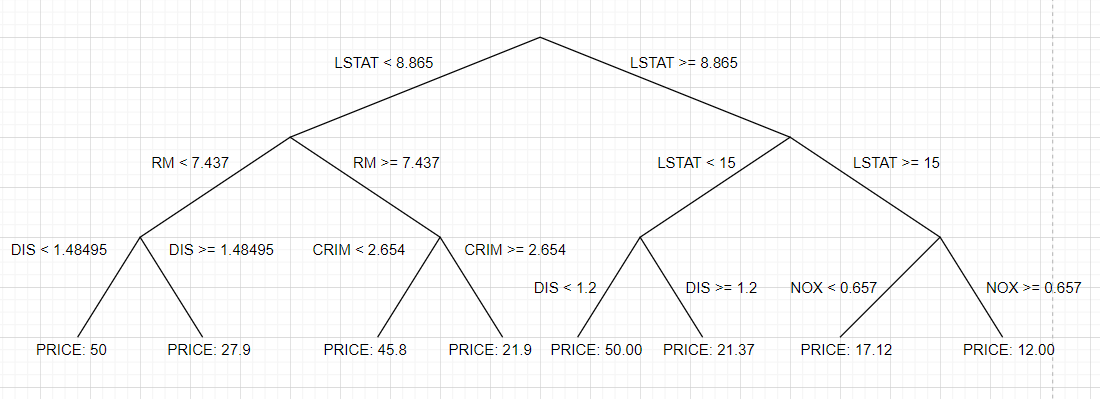

## **(10 pts)** Task 3: Evaluation

**(5 pts)** Now is time to pick the best maximum depth and observe your tree's performance! Implement a 5-fold cross validation procedure to experiment with maximum depths from 3 to 10. Report mean and standard deviation for each depth and pick the best one. For comparison you can use $R^2$, which is a metric frequently used to evaluate regression models. You can use `r2_score` function of `scikit-learn` and read more [here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score).

In [33]:
def calc_r2_score(root,X_test,y_test):
    sample_size = np.size(X_test,0)
    estimated_test_label = np.zeros((sample_size))
    actual_test_label = y_test
    for i in range(sample_size):
        test_sample_x = X_test[i,:]
        estimated_test_label[i] = estimate_value(root,test_sample_x)
    test_error = actual_test_label.T-estimated_test_label
    return r2_score(actual_test_label.T,estimated_test_label)

In [34]:
depth_values = np.arange(3,11)
depth_values

array([ 3,  4,  5,  6,  7,  8,  9, 10])

In [35]:
# from the project 1:
#def depth_cross_validation(X_train,y_train,depth_values):
r2_score_values = np.zeros((np.size(depth_values),5))
np.random.seed(1)
shuffle = np.random.permutation(400)
shuffled_x=X_train[shuffle,:]
shuffled_y=y_train[shuffle]
folds_trainx=np.array_split(shuffled_x,5)#shuffled and split x data
folds_trainy=np.array_split(shuffled_y,5)#shuffled and split y
kfold_test_data_vector = []#test data vector for 5 test cases
kfold_test_label_vector = []#label vector for 5 test cases
for i in range (5):
    kfold_test_data_vector.append(folds_trainx[i])#each part of shuffled x data is appended to test data vector
    kfold_test_label_vector.append(folds_trainy[i])#each part of shuffled y is appended to test label vector

kfold_train_data_vector = []#training data vector for 5 training cases
kfold_train_label_vector = []#label vector for 5 training cases

for i in range (5):
    temp_data_vector = []#to merge other 4 data folds 
    temp_label_vector = []#to merge other 4 label folds 
    for j in range (5):
        if i != j: #if the fold is not the test fold, merge it 
            temp_data_vector.extend(kfold_test_data_vector[j]) #merged 4 data folds (training data for cross validation)
            temp_label_vector.extend(kfold_test_label_vector[j]) #merged 4 label folds (training label for cross validation)
    kfold_train_data_vector.append(temp_data_vector)#training data is appended to training data vector
    kfold_train_label_vector.append(temp_label_vector)#training label is appended to training label vector


In [36]:
for d in range(np.size(depth_values)):
    for k in range(5):
        temp_root = Node(np.array(kfold_train_data_vector[k]),np.array(kfold_train_label_vector[k]),0)#training
        tree_split(temp_root,depth_values[d])
        r2_score_values[d,k] = calc_r2_score(temp_root,np.array(kfold_test_data_vector[k]),np.array(kfold_test_label_vector[k]).T)

In [37]:
r2_score_values

array([[0.77879059, 0.71189176, 0.81830478, 0.61415055, 0.78728286],
       [0.83929427, 0.55967114, 0.8216544 , 0.64978517, 0.83240008],
       [0.83772992, 0.59801806, 0.8401991 , 0.66982865, 0.81136934],
       [0.85847581, 0.59534651, 0.81570595, 0.75210391, 0.81720887],
       [0.84892971, 0.57052909, 0.80714162, 0.73910607, 0.82001507],
       [0.81346726, 0.58841762, 0.79033532, 0.73122883, 0.81737567],
       [0.79989452, 0.57494354, 0.78846006, 0.74436163, 0.8189355 ],
       [0.80013948, 0.57118178, 0.78880246, 0.7312851 , 0.82013883]])

In [38]:
#mean for each depth(3-4-5-6-7-8-9-10)
score_means = np.mean(r2_score_values, axis=1)
score_means

array([0.74208411, 0.74056101, 0.75142901, 0.76776821, 0.75714431,
       0.74816494, 0.74531905, 0.74230953])

In [39]:
#std for each depth
score_stds = np.std(r2_score_values, axis=1)
score_stds

array([0.0727715 , 0.11464747, 0.0991104 , 0.09267674, 0.10002764,
       0.08560245, 0.08864281, 0.09052021])

Text(0.5, 1.0, 'Means of R2 Score')

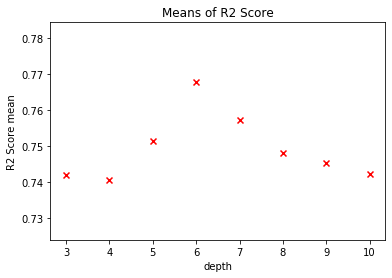

In [40]:
plt.scatter(depth_values,score_means,marker='x',color='red')
plt.xlabel("depth")
plt.ylabel("R2 Score mean")
plt.title("Means of R2 Score")

Text(0.5, 1.0, 'Std of R2 Score')

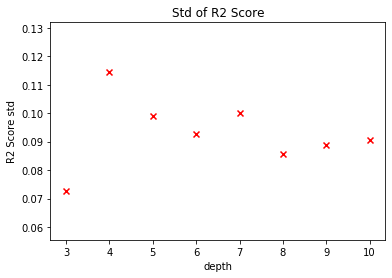

In [41]:
plt.scatter(depth_values,score_stds,marker='x',color='red')
plt.xlabel("depth")
plt.ylabel("R2 Score std")
plt.title("Std of R2 Score")

Optimal depth is 6.

**(5 pts)** To conclude, train your tree one last time on the whole training data with the depth you picked in the previous section. Generate predictions on both training and test sets and report $R^2$ scores.

In [42]:
root6 = Node(samples_X,samples_y,0)
tree_split(root6,6)#training # depth of 6

In [43]:
calc_r2_score(root6,X_train,y_train.T) #training r2 score

0.9421790670387243

In [44]:
calc_r2_score(root6,X_test,y_test) #test r2 score

0.8345513163278523